In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path= '/content/drive/MyDrive/fer2013.csv'

In [ ]:
# Read the CSV file and split the 'pixels' column into multiple columns
df = pd.read_csv(path)
df = pd.concat([df, df['pixels'].str.split(' ', expand=True)], axis=1)

In [ ]:
# Extract the emotion labels and remove unnecessary columns
y = df['emotion'].values
df.drop(columns=['emotion'], inplace=True)
df.drop(columns=['pixels'], inplace=True)
df.drop(columns=['Usage'], inplace=True)
X = df.values

# Normalize the pixel values
X = X.astype(np.float64)/255.0

# Reshape the input data to fit the expected model input shape
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [ ]:
df.values.shape

(35887, 2304)

In [ ]:
# Split the data into training, testing, and validation sets
num_class = len(set(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

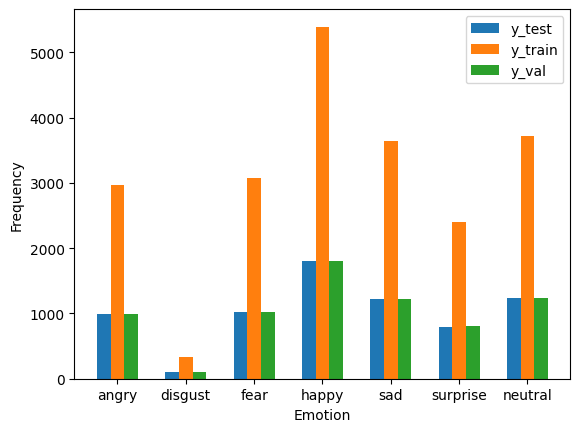

In [ ]:
# Plot the distribution of emotions in each dataset
counts_test = np.bincount(y_test, minlength=7)
counts_train = np.bincount(y_train, minlength=7)
counts_val = np.bincount(y_val, minlength=7)

x = np.array([0, 1, 2, 3, 4, 5, 6])
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plt.bar(x - 0.2, counts_test, width=0.2, label='y_test')
plt.bar(x, counts_train, width=0.2, label='y_train')
plt.bar(x + 0.2, counts_val, width=0.2, label='y_val')

plt.xticks(x, labels)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Convert the emotion labels into one-hot vectors
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
y_val = (np.arange(num_class) == y_val[:, None]).astype(np.float32)

In [ ]:
# Define the model architecture
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    
    # Add convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Add output layer with softmax activation
    model.add(Dense(7, activation='softmax', kernel_initializer='he_uniform'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model        

In [ ]:
# Define the model architecture
def past_model():
    model = Sequential()
    input_shape = (48,48,1)
    
    # Add convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))

    # Add output layer with softmax activation
    model.add(Dense(7, activation='softmax', kernel_initializer='he_uniform'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model        

In [ ]:
# Define the model architecture
def new_model():
    model = Sequential()
    input_shape = (48,48,1)
    
    # Add convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3),  padding='same', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),  padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3),  padding='same', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3),  padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(32,  kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    

    # Add output layer with softmax activation
    model.add(Dense(7, activation='softmax', kernel_initializer='he_uniform'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model        

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
N, D1, D2, D3 = X_train.shape
X_train = X_train.reshape(N, 2304)
X_train.shape

(21531, 2304)

In [ ]:
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
N, D = X_train_oversampled.shape
X_train_oversampled = X_train_oversampled.reshape(N, 48, 48, 1)
X_train_oversampled.shape

(37751, 48, 48, 1)

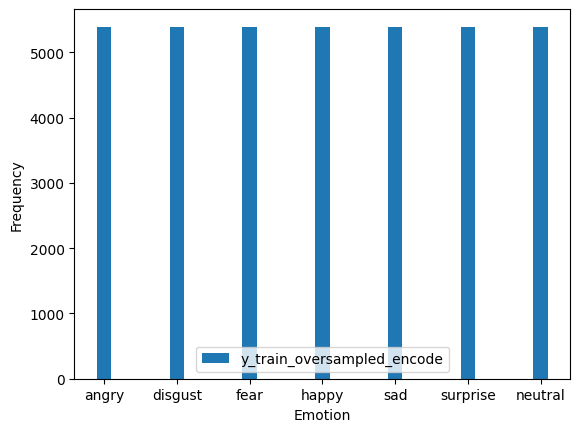

In [ ]:
# Plot the distribution of emotions in each dataset
y_train_oversampled_encode = np.argmax(y_train_oversampled, axis=1)
counts_train = np.bincount(y_train_oversampled_encode, minlength=7)

x = np.array([0, 1, 2, 3, 4, 5, 6])
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plt.bar(x, counts_train, width=0.2, label='y_train_oversampled_encode')

plt.xticks(x, labels)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Create an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_oversampled)

In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

n_models = 5
models = []

for i in range(n_models):
    print(f'Training model {i+1}')
    model = new_model()

    checkpoint = ModelCheckpoint(
        f'model_{i+1}.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    model.fit(
        datagen.flow(X_train_oversampled, y_train_oversampled, batch_size=32),
        validation_data=(X_val, y_val),
        epochs=40,
        callbacks=[checkpoint]
    )

    best_model = load_model(f'model_{i+1}.h5')
    models.append(best_model)

Training model 1
Epoch 1/40
1179/1180 [============================>.] - ETA: 0s - loss: 1.7743 - accuracy: 0.2940
Epoch 1: val_accuracy improved from -inf to 0.40958, saving model to model_1.h5
1180/1180 [==============================] - 32s 20ms/step - loss: 1.7741 - accuracy: 0.2941 - val_loss: 1.5115 - val_accuracy: 0.4096
Epoch 2/40
1179/1180 [============================>.] - ETA: 0s - loss: 1.4327 - accuracy: 0.4549
Epoch 2: val_accuracy improved from 0.40958 to 0.45974, saving model to model_1.h5
1180/1180 [==============================] - 20s 17ms/step - loss: 1.4327 - accuracy: 0.4550 - val_loss: 1.4210 - val_accuracy: 0.4597
Epoch 3/40
1177/1180 [============================>.] - ETA: 0s - loss: 1.2713 - accuracy: 0.5201
Epoch 3: val_accuracy improved from 0.45974 to 0.51477, saving model to model_1.h5
1180/1180 [==============================] - 20s 17ms/step - loss: 1.2715 - accuracy: 0.5202 - val_loss: 1.2603 - val_accuracy: 0.5148
Epoch 4/40
1177/1180 [================

In [ ]:
# Plot the training and validation loss and accuracy
%matplotlib inline

# Define the emotion labels and number of classes
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = 7

# Get training and validation loss and accuracy from history
train_loss=h.history['loss']
val_loss=h.history['val_loss']
train_acc=h.history['accuracy']
val_acc=h.history['val_accuracy']

# Plot the training and validation loss
epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

# Plot the training and validation accuracy
plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

NameError: ignored

In [ ]:
def ensemble_predictions(models, X):
    predictions = [model.predict(X) for model in models]
    return np.mean(predictions, axis=0)

y_pred = ensemble_predictions(models, X_test)

225/225 [==============================] - 1s 3ms/step


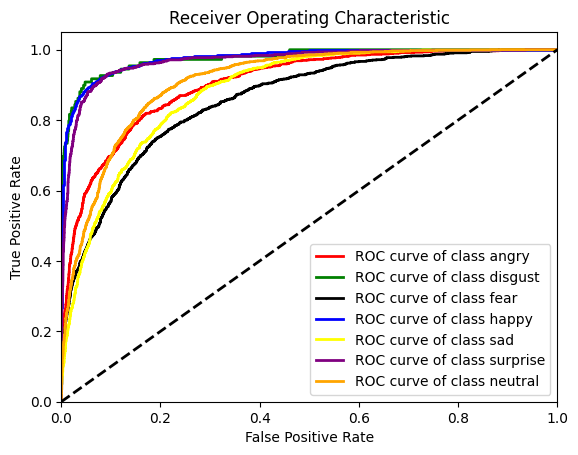

In [ ]:
# Calculate and plot the ROC curves for each class
#y_pred=model.predict(X_test)

new_label = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
y_pred_ravel = y_pred.ravel()
lw = 2
new_class = len(new_label)

fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['red', 'green', 'black', 'blue', 'yellow', 'purple', 'orange']
for i in range(new_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw,
             label=f'ROC curve of class {new_label[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate the confusion matrix and normalize it
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_label, y_pred_label)

cm = cm.astype('float')
row_sums = cm.sum(axis=1)
percentage_cm = cm / row_sums[:, np.newaxis]
percentage_cm = np.round(percentage_cm, 2)

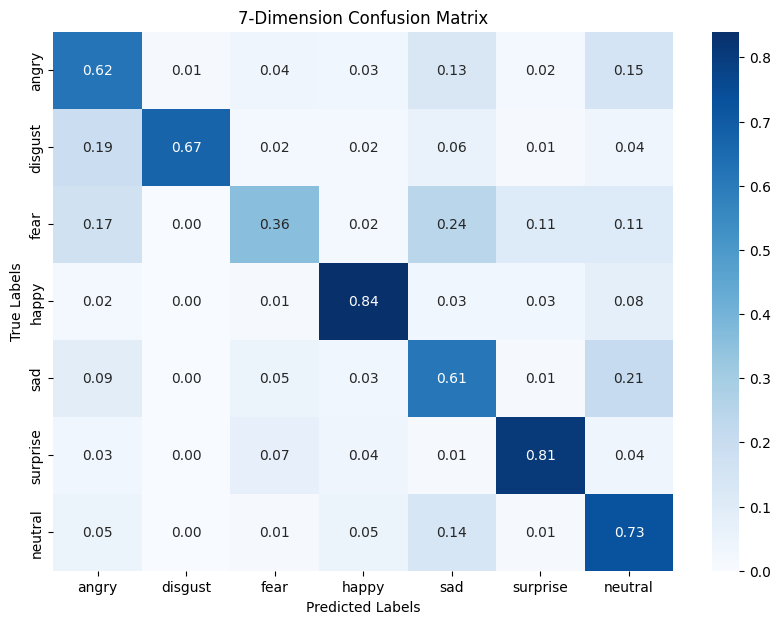

In [ ]:
# Plot the confusion matrix
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

plt.figure(figsize=(10, 7))
sns.heatmap(percentage_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('7-Dimension Confusion Matrix')

plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       991
           1       0.77      0.67      0.72       109
           2       0.65      0.36      0.46      1024
           3       0.90      0.84      0.87      1798
           4       0.55      0.61      0.58      1216
           5       0.76      0.81      0.78       800
           6       0.57      0.73      0.64      1240

    accuracy                           0.68      7178
   macro avg       0.68      0.66      0.67      7178
weighted avg       0.69      0.68      0.67      7178

